# Inventory Monitoring at Distribution Centers

## Problem Statement

There are a lot of labor requirements associated with manual inventory management, as well as the possibility of errors. So, there is a need for an effective inventory management.
Proper warehouse inventory management can save you money, including labor, storage, and fulfillment costs. This can be done by optimizing storage, investing in warehouse automation, organizing inventory to speed up the picking and packing process, and implementing technology to automate tasks that reduce human error.
Machine learning is one technology that can automate those processes. Computer vision can be used to automate inventory monitoring using convolution neural network to count the number of objects in each bin and ensure that delivery consignments contain the correct number of items. This notebooks contains the solution for this problem.

In [5]:
# TODO: Install any packages that you might need

In [113]:
# TODO: Import any packages that you might need
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role

In [114]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [115]:
import os
import json
import boto3
from tqdm import tqdm

In [4]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:28<00:00, 13.88it/s]


100%|██████████| 2299/2299 [02:46<00:00, 13.78it/s]


100%|██████████| 2666/2666 [03:22<00:00, 13.19it/s]


100%|██████████| 2373/2373 [02:56<00:00, 13.48it/s]


100%|██████████| 1875/1875 [02:29<00:00, 12.52it/s]


## Dataset
The Amazon Bin Image Dataset contains over 500,000 images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

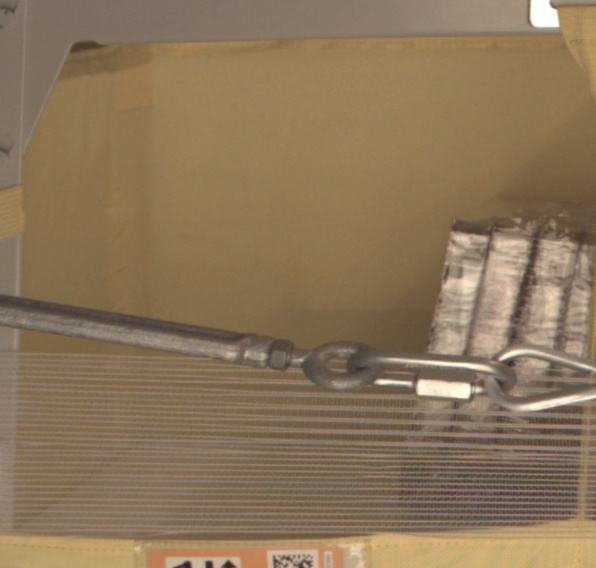

In [4]:
from PIL import Image
image = './train_data/1/00009.jpg'

import io
with open(image, "rb") as f:
    payload = f.read()
    display(Image.open(io.BytesIO(payload)))

In [ ]:
input_path = sagemaker_session.upload_data(path="train_data", bucket=bucket, key_prefix='project-inventory')

print(f'S3uri: {input_path}')

In [116]:
data_path = "s3://{}/{}/".format(bucket, "project-inventory")
output_path = "s3://{}/{}/".format(bucket, "output")
model_path = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAINING']= data_path
os.environ['SM_OUTPUT_DATA_DIR']= output_path
os.environ['SM_MODEL_DIR']= model_path

## Model Hyperparameter Tuning and Training
 This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

- learning rate - 0.0001 to 0.1
- batch size - 64, 128 and 256

In [81]:
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "batch_size": CategoricalParameter([64, 128, 256]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [82]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch-hpo',
    role=role,
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    output_path = output_path

)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [83]:
tuner.fit({"training": data_path}, wait=True)

..........................................................................................................................................................................!


In [84]:
tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-training-221104-1658',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:984124782249:hyper-parameter-tuning-job/pytorch-training-221104-1658',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'Test Loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 1,
   'MaxParallelTrainingJobs': 1},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'lr',
     'MinValue': '0.0001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"64"', '"128"', '"256"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'Test Loss',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator_class_name': '"PyTorch"',
   'sagemaker_estimator_module': '"sagemaker.pytorch.estima

In [85]:
tuner.describe()['HyperParameterTuningJobName']

'pytorch-training-221104-1658'

## Best Hyperparameter

In [86]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name=tuner.describe()['HyperParameterTuningJobName'])

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""64""",0.000749,pytorch-training-221104-1658-001-da2c3510,Completed,91.344391,2022-11-04 17:00:20+00:00,2022-11-04 17:11:10+00:00,650.0


In [117]:
TrainingJob = 'pytorch-training-221104-1658-001-da2c3510'

In [118]:
my_estimator = sagemaker.estimator.Estimator.attach(TrainingJob)


2022-11-04 17:11:12 Starting - Preparing the instances for training
2022-11-04 17:11:12 Downloading - Downloading input data
2022-11-04 17:11:12 Training - Training image download completed. Training in progress.
2022-11-04 17:11:12 Uploading - Uploading generated training model
2022-11-04 17:11:12 Completed - Resource released due to keep alive period expiry


In [119]:
my_estimator.hyperparameters()

{'_tuning_objective_metric': 'Test Loss',
 'batch_size': '"64"',
 'lr': '0.000748520739996759',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-hpo-2022-11-04-16-58-49-821"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-984124782249/pytorch-hpo-2022-11-04-16-58-49-821/source/sourcedir.tar.gz"'}

In [120]:
hyperparameters = {"batch_size": int(my_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "lr": my_estimator.hyperparameters()['lr']}
hyperparameters

{'batch_size': 64, 'lr': '0.000748520739996759'}

### Model Profiling and Debugging
For any SageMaker training jobs, the Debugger ProfilerReport rule invokes all of the monitoring and profiling rules and aggregates the rule analysis into a comprehensive report. Following this guide, download the report using the Amazon SageMaker Python SDK or the S3 console, and learn what you can interpret from the profiling results. (source: https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-profiling-report.html)

In [121]:
from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    rule_configs,
    ProfilerConfig,
    FrameworkProfile,
    CollectionConfig,
    DebuggerHookConfig)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig(collection_configs=collection_configs)

In [122]:
os.environ['SM_CHANNEL_TRAIN']= data_path

In [123]:
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="training-model",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.4",
    py_version="py3",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
)

In [124]:
estimator.fit({'train' : data_path },wait=True)

2022-11-04 18:34:16 Starting - Starting the training job...
2022-11-04 18:34:46 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-11-04 18:36:06 Downloading - Downloading input data............
2022-11-04 18:38:07 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-04 18:38:08,131 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-11-04 18:38:08,161 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-04 18:38:08,166 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-11-04 18:38:08,683 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py

In [125]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [126]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-11-04 18:48:47.660 ip-172-16-127-110.ec2.internal:6455 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-04 18:48:47.809 ip-172-16-127-110.ec2.internal:6455 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-984124782249/training-model-2022-11-04-18-34-15-701/debug-output
[2022-11-04 18:48:48.555 ip-172-16-127-110.ec2.internal:6455 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 533 more expected)', IncompleteRead(0 bytes read, 533 more expected)) while reading s3://sagemaker-us-east-1-984124782249/training-model-2022-11-04-18-34-15-701/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [127]:
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-11-04 18:49:23.307 ip-172-16-127-110.ec2.internal:6455 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-11-04 18:49:24.331 ip-172-16-127-110.ec2.internal:6455 INFO trial.py:210] Loaded all steps
49
198


In [128]:
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight']

In [129]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


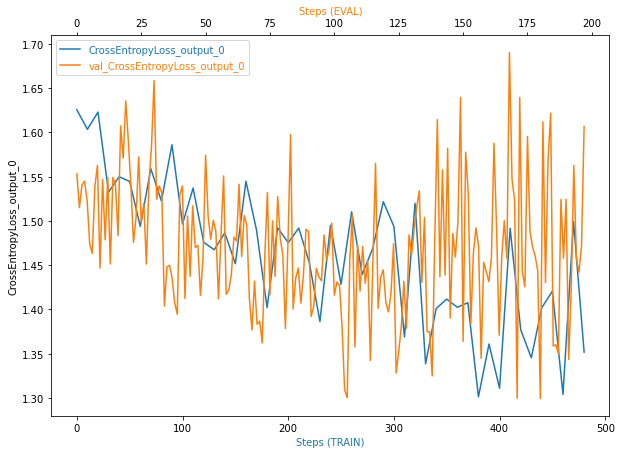

In [130]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

Seems to have some overfitting. We could try different neural network architecture or use some regularization like dropout.

In [131]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [132]:
! aws s3 ls {rule_output_path} --recursive

2022-11-04 18:45:29     361663 training-model-2022-11-04-18-34-15-701/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-11-04 18:45:29     208574 training-model-2022-11-04-18-34-15-701/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-11-04 18:45:25        192 training-model-2022-11-04-18-34-15-701/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-11-04 18:45:25      17797 training-model-2022-11-04-18-34-15-701/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-11-04 18:45:25        126 training-model-2022-11-04-18-34-15-701/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-11-04 18:45:25        327 training-model-2022-11-04-18-34-15-701/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-11-04 18:45:25       3924 training-model-2022-11-04-18-34-15-701/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottle

In [133]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-984124782249/training-model-2022-11-04-18-34-15-701/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-984124782249/training-model-2022-11-04-18-34-15-701/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-984124782249/training-model-2022-11-04-18-34-15-701/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-984124782249/training-model-2022-11-04-18-34-15-701/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-98412

In [134]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [135]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [136]:
import shutil
shutil.make_archive("./profiler_report_file", "zip", "ProfilerReport")

'/home/ec2-user/SageMaker/profiler_report_file.zip'

### Model Deploying


In [137]:
estimator.model_data

's3://sagemaker-us-east-1-984124782249/training-model-2022-11-04-18-34-15-701/output/model.tar.gz'

In [140]:
model_location=estimator.model_data

In [141]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [144]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='endpoint.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [145]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

## Querying

In [148]:
import requests

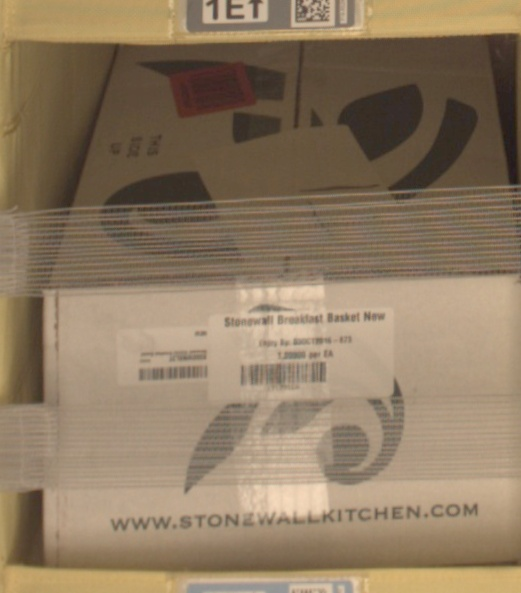

In [155]:
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/555.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [163]:
from sagemaker.serializers import IdentitySerializer
import numpy as np

In [158]:
predictor.serializer = IdentitySerializer("image/png")

In [160]:
response = predictor.predict(img_bytes)

In [161]:
response

[[-3.1894218921661377,
  0.16693083941936493,
  0.7788431644439697,
  0.41088956594467163,
  -0.43211162090301514]]

In [164]:
np.argmax(response, 1)

array([2])